<a href="https://colab.research.google.com/github/tigju/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [236]:
# TODO - your code!
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2020-02-02 20:48:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data.2’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.1s    

2020-02-02 20:48:07 (137 KB/s) - ‘house-votes-84.data.2’ saved [18171/18171]



In [0]:
import pandas as pd

In [0]:
import scipy.stats as stats
import numpy as np

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from scipy.stats import ttest_1samp, t

In [0]:
column_headers = ['party','handicapped-infants','water-project', 'budget','physician-fee-freeze', 'el-salvador-aid',
                  'religious-groups','anti-satellite-ban', 'aid-to-contras','mx-missile','immigration',
                  'synfuels', 'education', 'right-to-sue','crime','duty-free', 'south-africa']
voting_records = pd.read_csv('house-votes-84.data', header=None, names=column_headers, na_values='?')

In [0]:
voting_records = voting_records.replace({'y': 1, 'n': 0})

In [243]:
voting_records.shape

(435, 17)

In [244]:
voting_records.isnull().sum()

party                     0
handicapped-infants      12
water-project            48
budget                   11
physician-fee-freeze     11
el-salvador-aid          15
religious-groups         11
anti-satellite-ban       14
aid-to-contras           15
mx-missile               22
immigration               7
synfuels                 21
education                31
right-to-sue             25
crime                    17
duty-free                28
south-africa            104
dtype: int64

In [245]:
dem = voting_records[voting_records['party'] == 'democrat']
dem

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,democrat,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN
426,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
428,democrat,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
429,democrat,1.0,0.0,1.0,0.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,1.0,1.0


In [246]:
rep = voting_records[voting_records['party'] == 'republican']
rep

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,republican,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
430,republican,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
432,republican,0.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
433,republican,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,1.0


# Look into one single bill 'Budget' for democrat voters

1) Null hypothesis that the votes y/n are even among democrats

2) Alternative hypothesis that the votes are differ.

3) Confidence Level 95%

4) Find Confidence Interval

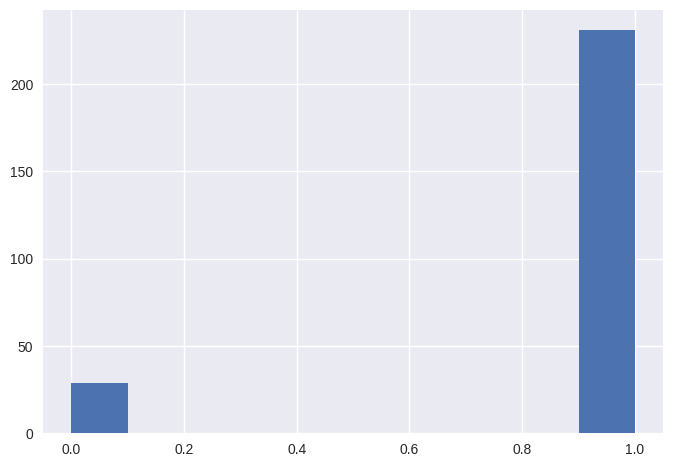

In [247]:
dem_budget_nona = dem['budget'].dropna()
plt.hist(dem_budget_nona);

In [0]:
def confidence_interval(data, confidence=0.95):
    """
    Calculate a confidence interval around a sample mean for given data.
    Using t-distribution and two-tailed test, default 95% confidence. 

    Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval

    Returns:
    tuple of (mean, lower bound, upper bound)
    """
    mean = np.mean(data)
    data = np.array(data)
    n = len(data)
    stderr = np.std(data)/np.sqrt(n)
    moe = stderr * stats.t.ppf((1 + confidence) / 2.0, n) # just looking up the corresponding t-stat.
    return (mean, mean - moe, mean + moe)

In [249]:
dem_budget_ci = confidence_interval(dem_budget_nona)
dem_budget_ci

(0.8884615384615384, 0.8500183539155728, 0.926904723007504)

In [250]:
dem_budget_nona.mean()

0.8884615384615384

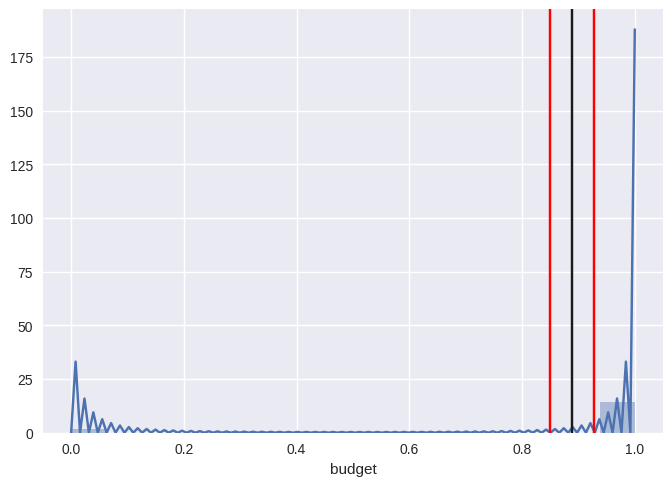

In [251]:
sns.distplot(dem_budget_nona)
CI = dem_budget_ci
plt.axvline(x=CI[1], color='red')
plt.axvline(x=CI[2], color='red')
plt.axvline(x=CI[0], color='k');

In [252]:
# using scipy built-in function t.interval for Confidence Interval
# Sample Size
n = len(dem_budget_nona)
# Degrees of Freedom is the length bacause we take the all data (not sample of data)
dof = n
# The Mean of Means:
mean = np.mean(dem_budget_nona)
# Sample Standard Deviation
sample_std = np.std(dem_budget_nona, ddof=0)
# Standard Error
std_err = sample_std/np.sqrt(n)

CI = t.interval(.95, dof, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI)

95% Confidence Interval:  (0.8500183539155728, 0.926904723007504)


In [253]:
statistics_budget, pvalue_budget = ttest_1samp(dem_budget_nona, 0.5)
print('Statistic:', statistics_budget,'P-value:', pvalue_budget)

Statistic: 19.859406568628835 P-value: 5.759315046608634e-54


Conclusion: I would only see that the votes are even 5% of the time for the Budget Bill among democrats, so I reject my null hypothesis.

89% (0.89) is the point estimate, and +/- 4% (the interval  [0.85,0.93] ) is the confidence interval.

# Look up the water-project bill for both parties

1) Null Hypothesis that the republicans and democrats voted equaly on average for water-project bill

2) Alternative Hypothesis that parties voted differently for water project bill

3) Confidence Level 95%

4) Find Confidence Interval

In [254]:
dem_mean = dem['water-project'].mean()
dem_mean

0.502092050209205

In [255]:
rep_mean = rep['water-project'].mean()
rep_mean

0.5067567567567568

[0.50209205 0.50675676]


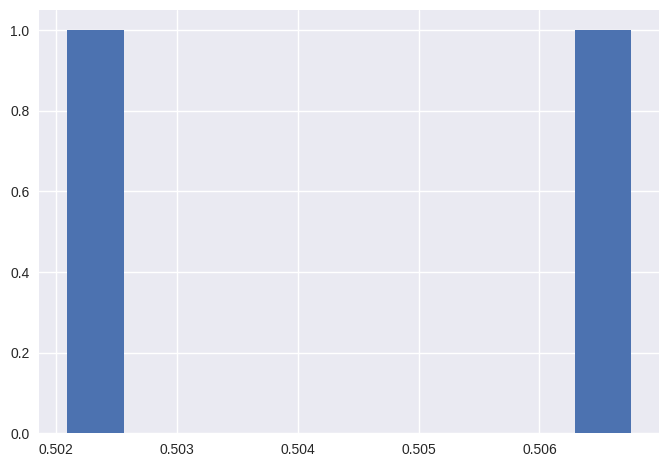

In [256]:
means_array = np.array([dem_mean, rep_mean])
print(means_array)
plt.hist(means_array);

In [257]:
# Using scipy t.interval
# number of means
n = len(means_array)
n

2

In [258]:
# degrees of freedom are the same , because we take all data (not sample)
dof = n
dof

2

In [259]:
# the mean of means
mean_of_means = means_array.mean()
mean_of_means

0.5044244034829809

In [260]:
# standard deviation
stdev = np.std(means_array)
stdev

0.0023323532737759

In [261]:
# standard error
stderr = stdev/n**0.5
stderr

0.0016492228160095831

In [262]:
C_Interval = t.interval(.95, dof, loc=mean_of_means, scale=stderr)
C_Interval

(0.4973283704314453, 0.5115204365345165)

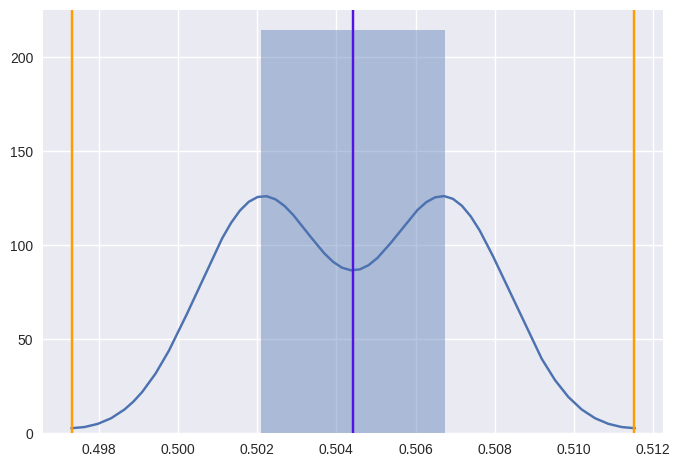

In [263]:
# visualize confidence interval
sns.distplot(means_array);
plt.axvline(x=mean_of_means, color='#5112e5');
plt.axvline(x=C_Interval[0], color='#ff9d00')
plt.axvline(x=C_Interval[1], color='#ff9d00');

In [264]:
ttest_1samp(means_array, 0.5)

Ttest_1sampResult(statistic=1.896969696969675, pvalue=0.3088472230302254)

Conclusion: I **fail to reject** null hypothesis that democrats and republicans voted equal on average for water-project bill. Confidence Interval is between $\approx$ 0.49 and $\approx$ 0.51 with the mean $\approx$ 0.5. 

50% (0.5) is the point estimate, and +/- 1% (the interval  [0.49,0.51] ) is the confidence interval.

# Observation on Republicans voted Yes or No in general for every bill

1) Null hypothesis that they voted evenly 

2) Alternative hypothesis that they voted differently.

3) Confidence level 95%

4) Find Confidence Interval

In [265]:
rep = rep.dropna()
rep

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
28,republican,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
30,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
33,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
35,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,republican,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
416,republican,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
420,republican,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
427,republican,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [266]:
rep_means = rep[1:].mean().values
rep_means

array([0.21495327, 0.46728972, 0.1588785 , 0.99065421, 0.95327103,
       0.86915888, 0.27102804, 0.14953271, 0.14018692, 0.57943925,
       0.1588785 , 0.85046729, 0.8411215 , 0.98130841, 0.11214953,
       0.6635514 ])

In [267]:
CI = confidence_interval(rep_means)
CI

(0.5251168224299065, 0.3450765400098871, 0.705157104849926)

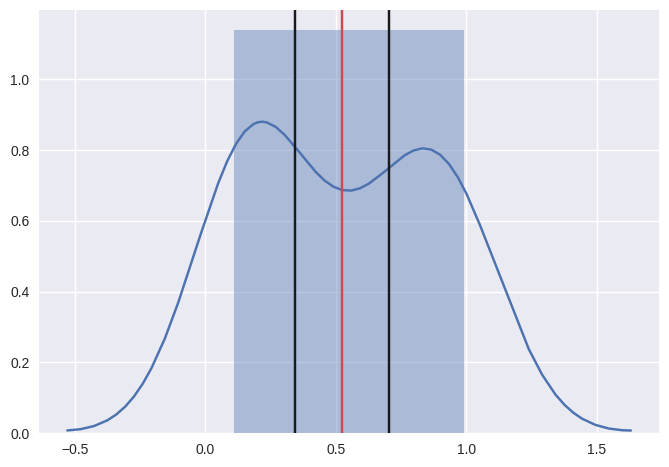

In [268]:
sns.distplot(rep_means)
plt.axvline(x=CI[1], color='k')
plt.axvline(x=CI[2], color='k')
plt.axvline(x=CI[0], color='r');

In [269]:
# Using t.interval 
# Sample Size
n = len(rep_means)
# Degrees of Freedom
dof = n
# The Mean of Means:
mean = np.mean(rep_means)
# Sample Standard Deviation
sample_std = np.std(rep_means, ddof=0)
# Standard Error
std_err = sample_std/np.sqrt(n)

CI = t.interval(.95, dof, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI)

95% Confidence Interval:  (0.3450765400098871, 0.705157104849926)


In [270]:
# pick a value for my null hypothesis and check the p-value
ttest_1samp(rep_means, .5)

Ttest_1sampResult(statistic=0.2863499478785454, pvalue=0.7785271500056743)

**Conclusion:** I would see that the votes are even 95% of the time for all bills in general that republicans voted.

A null hypothesis that's just inside of our confidence interval == fail to reject, 

therefore I fail to reject Null Hypothesis that Republicans voted on average equally for the bills in general. 



#Observation on Democrats voted Yes or No in general for every bill

1) Null hypothesis that they voted evenly 

2) Alternative hypothesis that they voted differently.

3) Confidence level 95%

4) Find Confidence Interval

In [271]:
dem = dem.dropna()
dem

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
19,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
23,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
25,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
26,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,democrat,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
422,democrat,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
423,democrat,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
426,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [272]:
dem_means = dem[1:].mean().values
dem_means

array([0.59349593, 0.44715447, 0.85365854, 0.04878049, 0.19512195,
       0.43902439, 0.77235772, 0.83739837, 0.79674797, 0.53658537,
       0.51219512, 0.1300813 , 0.28455285, 0.34146341, 0.59349593,
       0.94308943])

In [273]:
CI = confidence_interval(dem_means)
CI

(0.5203252032520325, 0.3800259051618924, 0.6606245013421725)

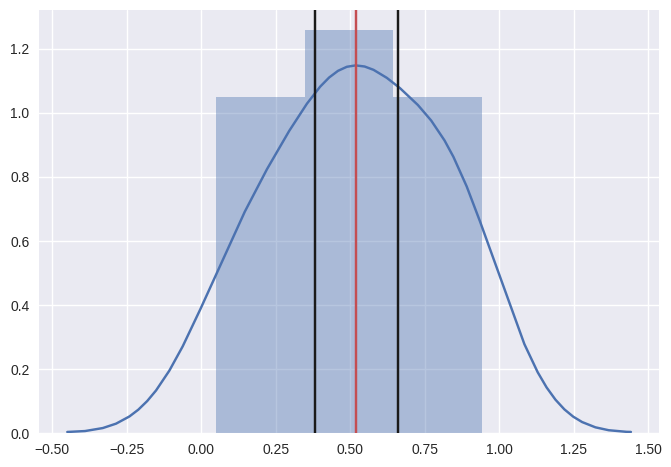

In [274]:
sns.distplot(dem_means)
plt.axvline(x=CI[1], color='k')
plt.axvline(x=CI[2], color='k')
plt.axvline(x=CI[0], color='r');

In [275]:
# Using t.interval 
# Sample Size
n = len(dem_means)
# Degrees of Freedom
dof = n
# The Mean of Means:
mean = np.mean(dem_means)
# Sample Standard Deviation
sample_std = np.std(dem_means, ddof=0)
# Standard Error
std_err = sample_std/np.sqrt(n)

CI = t.interval(.95, dof, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI)

95% Confidence Interval:  (0.3800259051618924, 0.6606245013421725)


In [276]:
# pick a value for my null hypothesis and check the p-value
ttest_1samp(rep_means, .5)

Ttest_1sampResult(statistic=0.2863499478785454, pvalue=0.7785271500056743)

**Conclusion:** I would see that the votes are even 95% of the time for all bills in general that democrats voted.

I **fail to reject** Null Hypothesis that Democrats voted on average equally for the bills in general. 


# Chi-squared tests:
1) Using nupmy

In [0]:
df_adult = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=' ?')
df_adult.shape
df_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
df_adult.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [0]:
df_adult.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [0]:
df_adult['education'].value_counts()

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64

In [0]:
df_adult['salary'].value_counts()

 <=50K    24720
 >50K      7841
Name: salary, dtype: int64

In [0]:
crosstab = pd.crosstab(df_adult['education'], df_adult['salary'], margins=True)
crosstab

salary,<=50K,>50K,All
education,,,
10th,871,62,933
11th,1115,60,1175
12th,400,33,433
1st-4th,162,6,168
5th-6th,317,16,333
7th-8th,606,40,646
9th,487,27,514
Assoc-acdm,802,265,1067
Assoc-voc,1021,361,1382


In [0]:
# contingency table
observed_values = pd.crosstab(df_adult['education'], df_adult['salary'])

salary,<=50K,>50K
education,,
10th,871,62
11th,1115,60
12th,400,33
1st-4th,162,6
5th-6th,317,16
7th-8th,606,40
9th,487,27
Assoc-acdm,802,265
Assoc-voc,1021,361


In [0]:
# cells that correspond to >50K
more_50 = crosstab.iloc[0:16, 1].values
more_50

array([  62,   60,   33,    6,   16,   40,   27,  265,  361, 2221,  306,
       1675,  959,    0,  423, 1387])

In [0]:
# cells that correspond to <=50K
less_50 = crosstab.iloc[0:16, 0].values
less_50

array([ 871, 1115,  400,  162,  317,  606,  487,  802, 1021, 3134,  107,
       8826,  764,   51,  153, 5904])

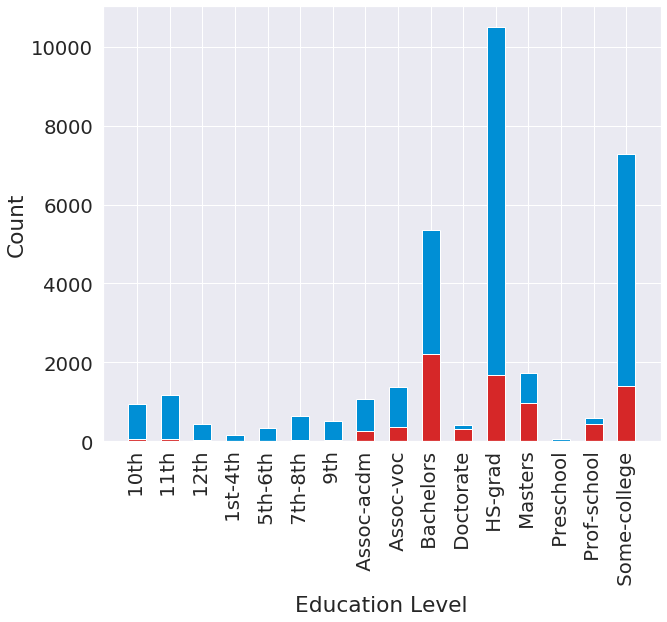

In [0]:
# Plot the bar chart
fig = plt.figure(figsize=(10,8))

categories = np.array(observed_values.index)
p1 = plt.bar(categories, more_50, 0.55, color='#d62728')
p2 = plt.bar(categories, less_50, 0.55, color='#008fd5', bottom=more_50)
# plt.legend((p2[0], p1[0]), ('<=50', '>50'))
plt.xticks(rotation=90)
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.show()

In [0]:
# get totals from rows
row_sum = crosstab.iloc[0:16, 2].values
row_sum

array([  933,  1175,   433,   168,   333,   646,   514,  1067,  1382,
        5355,   413, 10501,  1723,    51,   576,  7291])

In [0]:
# get totals from colunms

column_sum = crosstab.iloc[16,0:2].values
column_sum

array([24720,  7841])

In [0]:
# get total from row and colunms totals df_adult.shape[0] or -->
total = crosstab.loc['All','All']
total

32561

In [0]:
# Calculate expected value 
# make an expected value table
expected = []
for i in range(len(row_sum)):
  expected_row = []
  for col in column_sum:
    expected_value = col * row_sum[i]/total #
    expected_row.append(expected_value)
  expected.append(expected_row)

expected = np.array(expected)

# shape of expected should correspond to contingency table
print(expected.shape)
expected

(16, 2)


array([[ 708.3246829 ,  224.6753171 ],
       [ 892.04877   ,  282.95123   ],
       [ 328.72946163,  104.27053837],
       [ 127.54399435,   40.45600565],
       [ 252.81041737,   80.18958263],
       [ 490.43702589,  155.56297411],
       [ 390.22388747,  123.77611253],
       [ 810.05620221,  256.94379779],
       [1049.20119161,  332.79880839],
       [4065.46481988, 1289.53518012],
       [ 313.54565277,   99.45434723],
       [7972.25883726, 2528.74116274],
       [1308.08513252,  414.91486748],
       [  38.71871257,   12.28128743],
       [ 437.29369491,  138.70630509],
       [5535.25751666, 1755.74248334]])

In [0]:
observed = observed_values.values
observed

array([[ 871,   62],
       [1115,   60],
       [ 400,   33],
       [ 162,    6],
       [ 317,   16],
       [ 606,   40],
       [ 487,   27],
       [ 802,  265],
       [1021,  361],
       [3134, 2221],
       [ 107,  306],
       [8826, 1675],
       [ 764,  959],
       [  51,    0],
       [ 153,  423],
       [5904, 1387]])

In [0]:
chi_squared_np = ((observed - expected)**2/expected).sum()
print(f"Chi-squared: {chi_squared_np}")

Chi-squared: 4429.653302288619


In [0]:
# degrees of freedom for chi-squared test is different from n-1, because we are working with 2 variables ('education' and 'salary')
# degrees of freedom = (num_rows-1)*(num_columns - 1)
# calculate dof
dof = (len(row_sum)-1)*(len(column_sum)-1)
print(f"Degreesof freedom: {dof}")

Degreesof freedom: 15


We can use tables or function to translate our chi-squared statistics to p-value. Because chi-squared statistic is giant, we already know that p-value will be very close to zero.

In [0]:
from scipy.stats.distributions import chi2

print(f"P-value from chi-squared statistic: {chi2.sf(chi_squared_np, 15)}")

P-value from chi-squared statistic: 0.0


2) Using scipy:

In [0]:
# do the same chi-squared test with scipy
# I pass the function my contingency table (crosstab without margings)

chi_squared_scipy, p_value, dof, expected = stats.chi2_contingency(observed_values)

print(f"Chi-Squared: {chi_squared_scipy}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print(f"Expected: \n {np.array(expected)}")

Chi-Squared: 4429.653302288619
P-value: 0.0
Degrees of freedom: 15
Expected: 
 [[ 708.3246829   224.6753171 ]
 [ 892.04877     282.95123   ]
 [ 328.72946163  104.27053837]
 [ 127.54399435   40.45600565]
 [ 252.81041737   80.18958263]
 [ 490.43702589  155.56297411]
 [ 390.22388747  123.77611253]
 [ 810.05620221  256.94379779]
 [1049.20119161  332.79880839]
 [4065.46481988 1289.53518012]
 [ 313.54565277   99.45434723]
 [7972.25883726 2528.74116274]
 [1308.08513252  414.91486748]
 [  38.71871257   12.28128743]
 [ 437.29369491  138.70630509]
 [5535.25751666 1755.74248334]]


**Conclusion:** I reject the Null Hypothesis that Education Level and Salary are Independent from each other due to a p-value which is very close to 0. 

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)